Virginia Food Banks Dataset

In [49]:
# IMPORTS
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import folium
import json

In [50]:
def loadVAFoodBackData():
  VA_fb = pd.read_csv("DATA/VA_FoodBanks.csv")
  return VA_fb

VA_fb = loadVAFoodBackData()
print("")
print('---------------------------------------Original Data--------------------------------------------------------')
print(VA_fb.head(3))

#Removing data that may not be needed, can just remove a columns name from the list below to add it back
VA_fb = VA_fb.drop(columns=['Children Served via non-federal child nutrition programs','LAT','LON','MTW Status','Geopoint','Pounds of food distributed via non-federal child nutrition progr', 'FIPS', 'Households Served','Individuals Served'])
print("")
print('---------------------------------------Dropping un-needed columns--------------------------------------------')
print(VA_fb.head(3))

#missing = VA_fb.isnull().sum()
#print("")
#print('---------------------------------------NULL Values per column------------------------------------------------')
#print(missing)

#imputer = SimpleImputer(strategy='mean')
#numeric_columns = VA_fb.select_dtypes(include=['number']).columns
#VA_fb[numeric_columns] = imputer.fit_transform(VA_fb[numeric_columns])

#print("")
#print('---------------------------------------After filling null with mean------------------------------------------')
#missing = VA_fb.isnull().sum()
#print(missing)

print("")
print('---------------------------------------Data -----------------------------------------------')

# Fix County names
VA_fb['Locality'] = VA_fb['Locality'].str.title()
VA_fb['Locality'] = VA_fb['Locality'].str.replace(' Of ', ' of ')
VA_fb['Locality'] = VA_fb['Locality'].str.replace(' And ', ' and ')
VA_fb['Locality'] = VA_fb['Locality'].apply(lambda x: x if x.endswith('County') or x.endswith('City') else x + ' County')

print(VA_fb['Locality'].unique()) 


---------------------------------------Original Data--------------------------------------------------------
   Year    Month   FIPS        Locality  Households Served  \
0  2020  October   97.0  King and Queen                NaN   
1  2019    April  115.0  Mathews County                NaN   
2  2019   August   97.0  King and Queen                NaN   

   Individuals Served  Pounds of Food Distributed  \
0                 NaN                    156644.0   
1                 NaN                     21602.0   
2                 NaN                     51338.0   

   Children Served via non-federal child nutrition programs  \
0                                                NaN          
1                                                0.0          
2                                                NaN          

   Pounds of food distributed via non-federal child nutrition progr  \
0                                                NaN                  
1                                

In [51]:
#creates a new dataset VA_fb_yearly that has the distribution combined into one yearly number
VA_fb_yearly = VA_fb.groupby(['Locality', 'Year'], as_index=False).agg({'Pounds of Food Distributed': 'sum'})
VA_fb_yearly

,Locality,Year,Pounds of Food Distributed
0,Accomack County,2019,1248586.00
1,Accomack County,2020,582136.00
2,Albemarle County,2019,2079115.91
3,Albemarle County,2020,2592132.03
4,Albemarle County,2021,1263395.72
...,...,...,...
360,Wythe County,2019,256434.29
361,Wythe County,2020,308196.67
362,Wythe County,2021,166407.74
363,York County,2019,605970.00


In [52]:
#Loading Income
def loadIncome():
    income = pd.read_csv('DATA/Income_C.csv')
    return income

income  = loadIncome()
income = income.drop(columns=['ID','90% Confidence Interval'])
income['Name'] = income['Name'].str.replace(', Virginia', '', regex=False)
income['Name'] = income['Name'].str.replace(r' city$', ' City', regex=True)
income.head(5)

,Year,Name,Median Household Income*
0,2021,United States,"69,717"
1,2021,Virginia,"80,926"
2,2021,Accomack County,"50,949"
3,2021,Albemarle County,"91,849"
4,2021,Alleghany County,"49,197"


In [53]:
def loadPoverty():
  poverty = pd.read_csv('DATA/VA_Poverty.csv')
  return poverty

poverty = loadPoverty()
#Dropping state since ours is just virginia
poverty = poverty.drop(columns=['state'])
#Dropping the seperated data and keeping a total poverty number
columns_to_drop = ['B17020_002E','B17020_003E', 'B17020_004E', 'B17020_005E']
poverty['people_below_poverty_total'] = poverty['B17020_002E']
poverty = poverty.drop(columns=columns_to_drop)
#Changing date to only contain the year
poverty['year'] = pd.to_datetime(poverty['year']).dt.year
#Removing ",Virginia" from each county name so it can be matched with the food_bank if needed
poverty['county'] = poverty['county'].str.replace(', Virginia', '', regex=False)
poverty['county'] = poverty['county'].str.replace(r' city$', ' City', regex=True)
poverty.head(3)

/var/folders/0t/2vk628t954vdlcghtnkj4zn40000gn/T/ipykernel_6168/703105706.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  poverty['year'] = pd.to_datetime(poverty['year']).dt.year


,year,county,B17020_001E,county 1,people_below_poverty_total
0,2018,Tazewell County,40559,185,6550
1,2015,Accomack County,32582,1,6384
2,2015,Albemarle County,95348,3,9714


### **Adding years 2019-2021 based on poverty growth rate (-0.8%, 0.1%, 0.2%) and population growth rates (.54%, .94%, .23%)**

In [54]:

#In here I am adding the years 2019-2021 based on Virginia population growth and poverty growth for those years

population_growth_rates = {
    2019: 0.0054,
    2020: 0.0094,
    2021: 0.0023
}
poverty_growth_rates = {
    2019: -0.008,
    2020: 0.001,
    2021: 0.002
}

counties = poverty['county'].unique()
new_rows = []

for county in counties:
  last_year_data = poverty[poverty['county'] == county].loc[poverty['year'] == 2018]
  if last_year_data.empty:
        print(f"No data found for {county} in 2018. Skipping.")
        continue
  last_population = last_year_data['B17020_001E'].iloc[0]
  last_poverty = last_year_data['people_below_poverty_total'].iloc[0]
  last_county = last_year_data['county 1'].iloc[0]
  for year in range(2019,2022):
    new_population = int(last_population * (1 + population_growth_rates[year]))
    last_population = new_population
    new_poverty = int(last_poverty * (1 + poverty_growth_rates[year]))
    last_poverty = new_poverty
    new_rows.append({
      'year': year,
      'county': county,
      'B17020_001E': new_population,
      'people_below_poverty_total': new_poverty,
      'county 1': last_county
    })

new_data = pd.DataFrame(new_rows)
poverty = pd.concat([poverty, new_data], ignore_index=True)

poverty = poverty.sort_values(by=['county', 'year']).reset_index(drop=True)

#removing county with non complete data
poverty = poverty.groupby('county').filter(lambda x: len(x) > 1)

poverty

print(poverty['county'].unique())

No data found for Bedford City in 2018. Skipping.
['Accomack County' 'Albemarle County' 'Alexandria City' 'Alleghany County'
 'Amelia County' 'Amherst County' 'Appomattox County' 'Arlington County'
 'Augusta County' 'Bath County' 'Bedford County' 'Bland County'
 'Botetourt County' 'Bristol City' 'Brunswick County' 'Buchanan County'
 'Buckingham County' 'Buena Vista City' 'Campbell County'
 'Caroline County' 'Carroll County' 'Charles City County'
 'Charlotte County' 'Charlottesville City' 'Chesapeake City'
 'Chesterfield County' 'Clarke County' 'Colonial Heights City'
 'Covington City' 'Craig County' 'Culpeper County' 'Cumberland County'
 'Danville City' 'Dickenson County' 'Dinwiddie County' 'Emporia City'
 'Essex County' 'Fairfax City' 'Fairfax County' 'Falls Church City'
 'Fauquier County' 'Floyd County' 'Fluvanna County' 'Franklin City'
 'Franklin County' 'Frederick County' 'Fredericksburg City' 'Galax City'
 'Giles County' 'Gloucester County' 'Goochland County' 'Grayson County'
 'Gr

In [55]:
poverty_selected = poverty[poverty['year'] >= 2019]
poverty_selected = poverty_selected.rename(columns={'county': 'Locality', 'year': 'Year'})
income = income.rename(columns={'Name':'Locality'})
combined_data = pd.merge(VA_fb_yearly, poverty_selected, how='inner', on=['Year','Locality'])
combined_data = pd.merge(combined_data, income, how='inner', on=['Year', 'Locality'])

combined_data = combined_data.rename(columns={'B17020_001E': 'Total Population', 'county 1': 'County Num'})

combined_data
print(combined_data['Locality'].unique())

['Accomack County' 'Albemarle County' 'Alexandria City' 'Alleghany County'
 'Amelia County' 'Amherst County' 'Appomattox County' 'Arlington County'
 'Augusta County' 'Bath County' 'Bedford County' 'Bland County'
 'Botetourt County' 'Bristol City' 'Brunswick County' 'Buchanan County'
 'Buckingham County' 'Buena Vista City' 'Campbell County'
 'Caroline County' 'Carroll County' 'Charles City County'
 'Charlotte County' 'Charlottesville City' 'Chesapeake City'
 'Chesterfield County' 'Clarke County' 'Colonial Heights City'
 'Covington City' 'Craig County' 'Culpeper County' 'Cumberland County'
 'Danville City' 'Dickenson County' 'Dinwiddie County' 'Emporia City'
 'Essex County' 'Fairfax County' 'Fauquier County' 'Floyd County'
 'Fluvanna County' 'Franklin City' 'Franklin County' 'Frederick County'
 'Fredericksburg City' 'Galax City' 'Giles County' 'Gloucester County'
 'Goochland County' 'Grayson County' 'Greene County' 'Greensville County'
 'Halifax County' 'Hampton City' 'Hanover County' 'H

In [56]:
combined_data.head(5)

,Locality,Year,Pounds of Food Distributed,Total Population,County Num,people_below_poverty_total,Median Household Income*
0,Accomack County,2019,1248586.00,32570,1,6386,"47,335"
1,Accomack County,2020,582136.00,32876,1,6392,"44,127"
2,Albemarle County,2019,2079115.91,99425,3,9597,"86,332"
3,Albemarle County,2020,2592132.03,100359,3,9606,"79,708"
4,Albemarle County,2021,1263395.72,100589,3,9625,"91,849"


In [57]:
combined_data

,Locality,Year,Pounds of Food Distributed,Total Population,County Num,people_below_poverty_total,Median Household Income*
0,Accomack County,2019,1248586.00,32570,1,6386,"47,335"
1,Accomack County,2020,582136.00,32876,1,6392,"44,127"
2,Albemarle County,2019,2079115.91,99425,3,9597,"86,332"
3,Albemarle County,2020,2592132.03,100359,3,9606,"79,708"
4,Albemarle County,2021,1263395.72,100589,3,9625,"91,849"
...,...,...,...,...,...,...,...
359,Wythe County,2019,256434.29,28754,197,4432,"48,543"
360,Wythe County,2020,308196.67,29024,197,4436,"54,399"
361,Wythe County,2021,166407.74,29090,197,4444,"51,206"
362,York County,2019,605970.00,66408,199,3076,"91,535"


## Linear Regression: Finding a Pattern between lbs. of Food Distributed and # of People in Poverty

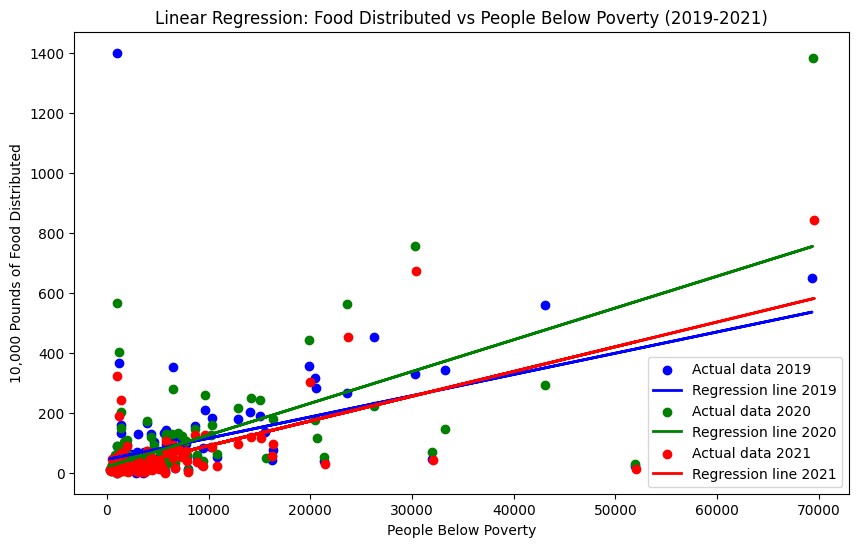

In [58]:
colors = {2019: 'blue', 2020: 'green', 2021: 'red'}
years = combined_data['Year'].unique()

plt.figure(figsize=(10, 6))

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    model_year = LinearRegression()
    model_year.fit(X_year, y_year)

    y_pred_year = model_year.predict(X_year)

    plt.scatter(X_year, y_year, color=colors[year], label=f'Actual data {year}')
    plt.plot(X_year, y_pred_year, color=colors[year], linewidth=2, label=f'Regression line {year}')

plt.xlabel('People Below Poverty')
plt.ylabel('10,000 Pounds of Food Distributed')
plt.title('Linear Regression: Food Distributed vs People Below Poverty (2019-2021)')
plt.legend()
plt.show()


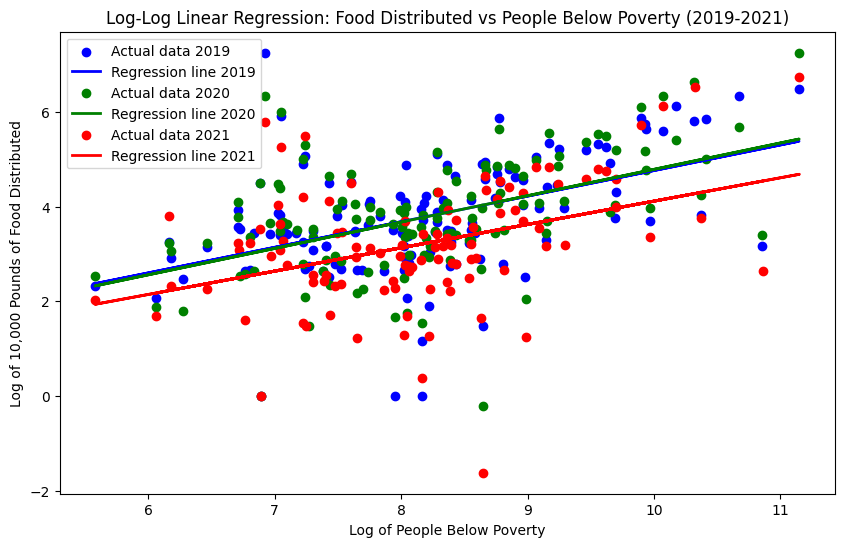

In [59]:
colors = {2019: 'blue', 2020: 'green', 2021: 'red'}
years = combined_data['Year'].unique()

plt.figure(figsize=(10, 6))

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    with np.errstate(divide='ignore'):
        X_log = np.log(X_year.replace(0, np.nan)).fillna(0)
        y_log = np.log(y_year.replace(0, np.nan)).fillna(0)
        #X_log = X_year
        #y_log = y_year

    model_year = LinearRegression()
    model_year.fit(X_log, y_log)

    y_pred_year = model_year.predict(X_log)

    plt.scatter(X_log, y_log, color=colors[year], label=f'Actual data {year}')
    plt.plot(X_log, y_pred_year, color=colors[year], linewidth=2, label=f'Regression line {year}')

plt.xlabel('Log of People Below Poverty')
plt.ylabel('Log of 10,000 Pounds of Food Distributed')
plt.title('Log-Log Linear Regression: Food Distributed vs People Below Poverty (2019-2021)')
plt.legend()
plt.show()


In [60]:
# Calculate residuals for each year
residuals = {}

for year in years:
    data_year = combined_data[combined_data['Year'] == year]
    X_year = data_year[['people_below_poverty_total']]
    y_year = data_year['Pounds of Food Distributed'] / 10000

    with np.errstate(divide='ignore'):
        X_log = np.log(X_year.replace(0, np.nan)).fillna(0)
        y_log = np.log(y_year.replace(0, np.nan)).fillna(0)

    model_year = LinearRegression()
    model_year.fit(X_log, y_log)

    y_pred_year = model_year.predict(X_log)
    residuals[year] = y_log - y_pred_year

heavy_threshold = 1.0
light_threshold = 0.5

labels = {}
for year in years:
    labels[year] = residuals[year].apply(lambda x: '++' if x > heavy_threshold else 
                                         ('+' if x > light_threshold else 
                                          ('--' if x < -heavy_threshold else 
                                           ('-' if x < -light_threshold else '○'))))
    
combined_data['Pounds of Food Distributed'] = combined_data['Pounds of Food Distributed'].astype(int)
    
# Add value for lbs / person below poverty
combined_data['lbs_per_person_below_poverty'] = (combined_data['Pounds of Food Distributed'] / combined_data['people_below_poverty_total']).round(1)

# Add labels to the combined_data dataframe
combined_data['Supply'] = combined_data.apply(lambda row: labels[row['Year']].loc[row.name], axis=1)

# Add poverty rate 
combined_data['poverty_rate'] = ((combined_data['people_below_poverty_total'] / combined_data['Total Population']) * 100).round(2).astype(str) + '%'

# Add residual to the combined_data dataframe
combined_data['Residual'] = combined_data.apply(lambda row: round(residuals[row['Year']].loc[row.name], 2), axis=1)

# Sort by most under-served
combined_data_sorted = combined_data.sort_values(by='Residual', ascending=True)

output = combined_data_sorted[['Locality', 'Year', 'people_below_poverty_total', 'poverty_rate','Pounds of Food Distributed', 'lbs_per_person_below_poverty', 'Residual', 'Supply']]

output.to_csv('OUTPUT/SUPPLY.csv', index=False)

## Visualization

In [61]:
df = pd.read_csv('OUTPUT/SUPPLY.csv')

# Convert relevant columns to numeric types
df['people_below_poverty_total'] = pd.to_numeric(df['people_below_poverty_total'], errors='coerce')
df['poverty_rate'] = df['poverty_rate'].str.rstrip('%').astype(float)
df['Pounds of Food Distributed'] = pd.to_numeric(df['Pounds of Food Distributed'], errors='coerce')
df['lbs_per_person_below_poverty'] = pd.to_numeric(df['lbs_per_person_below_poverty'], errors='coerce')

df_aggregated = df.groupby('Locality').agg({
    'people_below_poverty_total': 'mean',
    'poverty_rate': 'mean',
    'Pounds of Food Distributed': 'sum',
    'lbs_per_person_below_poverty': 'mean',
    'Supply': lambda x: x.mode()[0]  # Assuming mode is the most common supply level
}).reset_index()

df_aggregated = df_aggregated.round({
    'people_below_poverty_total': 2,
    'poverty_rate': 2,
    'Pounds of Food Distributed': 2,
    'lbs_per_person_below_poverty': 2
})

df_aggregated['poverty_rate'] = df_aggregated['poverty_rate'].astype(str) + '%'

va_map = folium.Map(location=[37.4316, -78.6569], zoom_start=8)

with open('va.geojson') as f:
    counties_geojson = json.load(f)

def get_supply_color(supply):
    if supply == '--':
        return 'red'
    elif supply == '-':
        return 'orange'
    elif supply == '○':
        return 'yellow'
    elif supply == '+':
        return 'lightgreen'
    elif supply == '++':
        return 'green'

for feature in counties_geojson['features']:
    locale_name = feature['properties']['name'] + " " + feature['properties']['TYPE']
    if locale_name in df['Locality'].values:
        supply_value = df[df['Locality'] == locale_name]['Supply'].values[0]
        feature['properties']['supply_color'] = get_supply_color(str(supply_value))
    else:
        # print(locale_name)
        feature['properties']['supply_color'] = 'purple'

m = folium.Map(location=[37.5, -78.5], zoom_start=7)

folium.GeoJson(
    counties_geojson,
    style_function=lambda feature: {
        'fillColor': feature['properties']['supply_color'],
        'color': feature['properties']['supply_color'],
        'weight': 2,
        'fillOpacity': 0.3
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'supply_color'],
        aliases=['County:', 'Supply Level:']
    )
).add_to(m)

m.save('va_supply_map.html')
